In [53]:
%matplotlib notebook

In [60]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pandas import DataFrame
import json
from datetime import datetime

In [61]:

variants_df = pd.read_csv('covid-variants.csv')
variants_df.rename(columns={'location':'country','date':'variant_date'},inplace=True)


countries_6_variants_df = variants_df.loc[variants_df['country'].isin(['United States','Canada','Germany','India','Japan','Sweden'])]

#df['DOB1'] = df['DOB'].dt.strftime('%m/%d/%Y')
#countries_6_variants_df['date'] = pd.to_datetime(countries_6_variants_df['date'],format ='%Y%m%d')
#countries_6_variants_df['date'] = countries_6_variants_df['date'].dt.strftime('%m/%d/%Y')

countries_6_variants_df.head()

,country,variant_date,variant,num_sequences,perc_sequences,num_sequences_total
13344,Canada,5/11/2020,Alpha,0,0.0,903
13345,Canada,5/11/2020,B.1.1.277,0,0.0,903
13346,Canada,5/11/2020,B.1.1.302,0,0.0,903
13347,Canada,5/11/2020,B.1.1.519,0,0.0,903
13348,Canada,5/11/2020,B.1.160,0,0.0,903


In [62]:
countries_6_variants_df['variant_date'] = pd.to_datetime(countries_6_variants_df.variant_date)

#df['DOB1'] = df['DOB'].dt.strftime('%m/%d/%Y')
#countries_6_variants_df['date'] = pd.to_datetime(countries_6_variants_df['date'],format ='%Y%m%d')
#countries_6_variants_df['date'] = countries_6_variants_df['date'].dt.strftime('%m/%d/%Y')

countries_6_variants_df.head()

C:\Users\radgu\AppData\Local\Temp\ipykernel_18040\3695259251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countries_6_variants_df['variant_date'] = pd.to_datetime(countries_6_variants_df.variant_date)


,country,variant_date,variant,num_sequences,perc_sequences,num_sequences_total
13344,Canada,2020-05-11,Alpha,0,0.0,903
13345,Canada,2020-05-11,B.1.1.277,0,0.0,903
13346,Canada,2020-05-11,B.1.1.302,0,0.0,903
13347,Canada,2020-05-11,B.1.1.519,0,0.0,903
13348,Canada,2020-05-11,B.1.160,0,0.0,903


In [63]:
face_covering_df = pd.read_csv('face-covering-policies-covid.csv')
face_covering_df.rename(columns={'Entity':'country','Day':'face_covering_date'},inplace=True)

countries_6_face_covering_df = face_covering_df.loc[face_covering_df['country'].isin(['United States','Canada','Germany','India','Japan','Sweden'])]

countries_6_face_covering_df.head(20)


,country,Code,face_covering_date,facial_coverings
22658,Canada,CAN,2020-01-01,0
22659,Canada,CAN,2020-01-02,0
22660,Canada,CAN,2020-01-03,0
22661,Canada,CAN,2020-01-04,0
22662,Canada,CAN,2020-01-05,0
22663,Canada,CAN,2020-01-06,0
22664,Canada,CAN,2020-01-07,0
22665,Canada,CAN,2020-01-08,0
22666,Canada,CAN,2020-01-09,0
22667,Canada,CAN,2020-01-10,0


In [70]:
# Combine the data into a single dataset
combined_dataset = pd.merge(countries_6_variants_df,countries_6_face_covering_df,how='outer',on='country')

combined_dataset.head()
combined_dataset.count()

# Display the data table for preview
#combined_dataset.count()


country                4835784
variant_date           4835784
variant                4835784
num_sequences          4835784
perc_sequences         4835784
num_sequences_total    4835784
Code                   4835784
face_covering_date     4835784
facial_coverings       4835784
dtype: int64

In [79]:
# Framinf the date range
A = '2020-01-01'
B = '2021-12-31'
data_truncated = countries_6_face_covering_df.loc[(combined_dataset['face_covering_date'] >= A) & (combined_dataset['face_covering_date'] <= B)]
data_truncated.head(5)
data_truncated.count()

countries_6_face_covering_df.count()

country               4562
Code                  4562
face_covering_date    4562
facial_coverings      4562
dtype: int64

In [92]:
canada_df = data_truncated.loc[data_truncated['country'].isin(['Canada'])]
canada_df_grouped = canada_df.groupby(['face_covering_date','facial_coverings'])
x_axis = canada_df[['facial_coverings']]
dates = canada_df[['face_covering_date']]
#canada_df_grouped.count()
#x_axis
dates
#plt.subplots(figsize=(120, 20))
plt.plot(dates,x_axis,linewidth=2, markersize=10,marker="p",color="orange")

TypeError: unhashable type: 'numpy.ndarray'

<IPython.core.display.Javascript object>


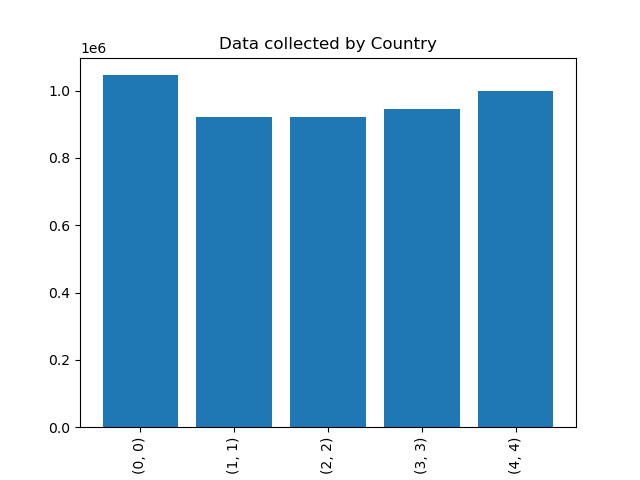

In [72]:
combined_dataset_grouped = combined_dataset.groupby("facial_coverings")


country_count = combined_dataset_grouped['facial_coverings'].value_counts()
x_axis = np.arange(len(country_count ))
plt.bar(x_axis,country_count)

plt.xticks(x_axis,country_count.index.values)
plt.xticks(rotation=90)

plt.title('Data collected by Country')
#plt.xlabel('Drug Regimen')
#plt.ylabel('Number of timepoints')
#x_axis
#drug_regimen_count.index.values
#plt.xticks(x_axis,drug_regimen_count.index.values)
#rotate x-axis labels.
#plt.xticks(rotation=90)

plt.show()
